# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example

#%matplotlib inline

/Users/andreas/phys/master/FERMI/venv/lib/python3.7/site-packages/gbm/plot/lal_post_subs.py:184: UserWarning: Basemap not installed. Some functionality not available.
  warnings.warn('Basemap not installed. Some functionality not available.')


CSPEC: data with a course time resulution --- with a good spectral resolution 

CTIME: they have course spectral resulution (8 channels) but a hight time resolution

# Notes

    GRB: Possible NS (magnetar) - BH merger
    >> See paper: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2205.05031.pdf
    >> pre-cursor could be explained by the strong magnetic field creating a barrier and halting radius for accretion
    
    Angles: Which angles to use? From FERMI or SWIFT-XRT?
    >> Angle seperation above 60 deg for both BGO detectors
    
    ToF: Missing ToF from KW to ASIM.
    >> Ask Anastasia from this
    
    LC: Very long GRB that last for T0+80s.
    >> Main event last for around T0+12.5s (in na2 detector)
    
    XSPEC: Uncertanty problem solved by grouping channels!
    >> but still hard to produce a good fit
    >> Aible to produce a good fit for the second (main) peak. 1.2 fit statistics
    >> Trying now to fit the two main peaks.
    
    
    >>In the circular the GBM team fitted this burst with a Band-function with E-peak on the interval: T0-1.264 s to T0+54.033

# Paths

In [5]:
GRB_id = "GRB211211A"
bn='bn211211549' #what is this? GRB id for Fermi
data_dir = '/Users/andreas/phys/master/FERMI/data/'+ bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

# Find the angle of the GRB wrt the GBM units

In [6]:
fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit
trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)

# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

glg_trigdat_all_bn211211549_v01.fit
660921004.65092


In [8]:
grb_ra, grb_dec = 212.271, 27.883  #put in manually

In [62]:
all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting
# Best illuminated units: n7, n6

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


n2 28.936
na 49.853
n1 73.267
n5 75.59
b0 78.593
n9 84.886
n0 94.495
b1 101.407
nb 104.726
n3 128.519
n6 128.828
n4 130.308
n7 145.304
n8 149.746


# Find temporal offset between GBM trigger time and others

In [12]:
#imports relevant modules
from gbm.time import Met
import datetime

In [13]:
# Convert from MET to UTC
t0METgbm = Met(trigdat.trigtime) #middle european time?
print(t0METgbm)
print(type(t0METgbm)) #checking which type it is
t0METgbm.datetime #interesting that is already an datetime object?

<Met seconds = 660921004.650920>
<class 'gbm.time.Met'>


datetime.datetime(2021, 12, 11, 13, 9, 59, 650920, tzinfo=datetime.timezone.utc)

In [14]:
#TODO: Find tshift between GBM and ASIM


ToF_Fermi_ASIM = 0.0049 #light travel time in seconds

str_t0ASIM = '2021-12-11T13:10:01.323' #T0 for KW
t0METASIM = t0METgbm.from_iso(str_t0ASIM) #Converting T0 KW to T0 met

#Q: Why are we adding both ToF? Double check this
t0MET = t0METASIM.add(ToF_Fermi_ASIM)  # To add seconds
tshift = t0MET - t0METgbm
print(tshift) #shift between ASIM trigger and GBM trigger

1.676979899406433


#  Extract data from selected unit(s)+

In [15]:
#unit = all_dets[idx_sort_angsep][4] #for selecting the detector that are have the lowest incident angle to the GRB
unit = trig_dets[0] #unit of the first trigger detector. What unit is this?
print(unit)

# Read TTE of selected unit
#Q: what is TTE? Time-Tagged Event. Assuming its that same as the tus array in ASIM data
fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'

# Filename of RSP for the selected unit
# Q: getting the filename for the response matirx? 
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v02.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

n2


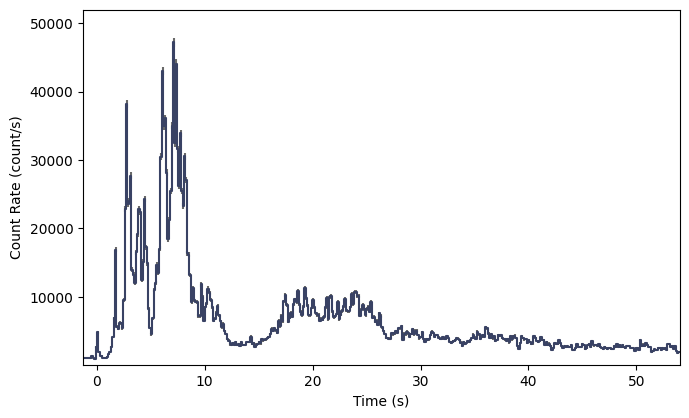

In [16]:
# open a TTE file
tte = TTE.open(fn_tte)
# bin to 2.048 s resolution, reference time is trigger time (coarse resolution to accurately model the bkg)
bint = 0.128 # 4ms binning
#phaii = tte.to_phaii(bin_by_time, bint, time_ref=0.0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time, bint, time_ref=tshift) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (8.0, 1000) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-1.264,54.033)

In [46]:
# Fit background
bkgd_times = [(-100.0, -2.0), (100,150)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 

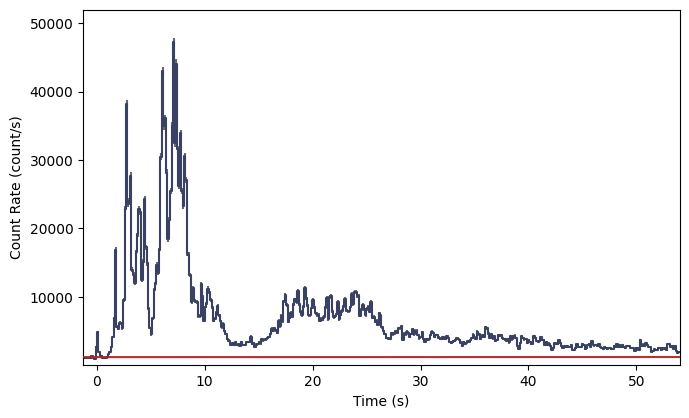

In [47]:
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
#type(bkgd)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (-1.264,54.033)
lcplot.xlim = view_range

In [48]:
# Ok, the fit is done, but how do we know if it is a good fit?  You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit, and try to figure out if it's a good fit based on that (Note: not always the best way to go).
backfitter.statistic/backfitter.dof

array([6.02041289, 1.07088133, 1.26950746, 0.96229838, 0.82442534,
       0.87422531, 0.8594453 , 0.85316437, 0.92667296, 0.97146606,
       0.95511351, 0.97090721, 0.98064405, 0.91411948, 1.00603446,
       0.95461486, 0.95734377, 0.98987338, 0.91508802, 0.9683384 ,
       0.99699077, 1.00196831, 0.99047904, 0.92196731, 0.83252881,
       0.83572668, 0.86634267, 0.86533559, 0.82379408, 0.79098792,
       0.8453788 , 0.95819068, 0.86413908, 0.8017188 , 0.88453898,
       0.88608553, 0.99054296, 0.85854094, 0.93200679, 0.88864992,
       0.87869087, 0.97519412, 0.91210328, 0.98191604, 0.95004848,
       0.89953245, 1.08910154, 1.0950069 , 1.18310095, 1.08509474,
       0.98462337, 1.11655968, 1.11773945, 1.17550392, 1.19141467,
       1.12404334, 1.23209913, 1.31681018, 1.09199977, 1.37591311,
       1.16726997, 1.16616414, 1.38389164, 1.38963935, 1.31902375,
       1.47225423, 1.35225484, 1.27880003, 1.29920182, 1.29182846,
       1.15614067, 1.23856773, 1.52773459, 1.65388576, 1.54972

In [49]:
# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])) | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1])) )[0]
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])) | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) )[0]

Normalised residuals: mean= -0.000313  std= 1.02
NormaltestResult(statistic=5.236676559232841, pvalue=0.07292394140008364)


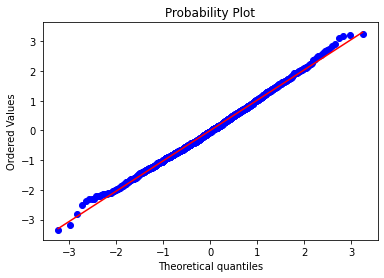

In [50]:
if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))

#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

In [51]:
# Now, we need to define a time interval of interest.  It could be a single bin, or it could be multiple bins.  Let's select the brightest two bins in this view.
# our lightcurve source selection

src_time = (1.6,8.8)
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

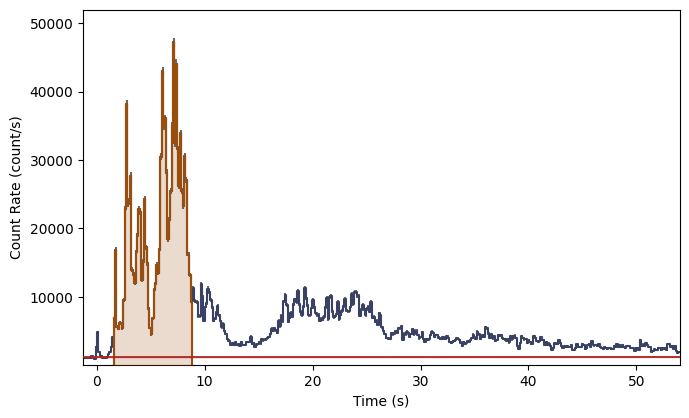

In [52]:
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = view_range

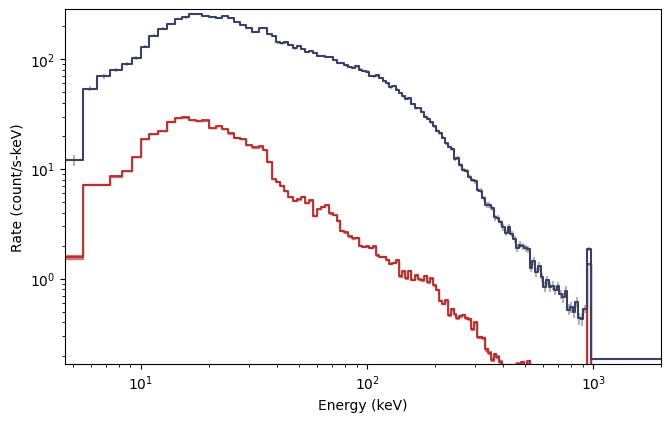

In [53]:
# The orange shading indicates the time bins you've selected as source signal.  You can also make a plot of the count spectrum during the selection  to see what the background model looks like in comparison to the data:
# the observed count spectrum during the source selection
spec_data = tte.to_spectrum(time_range=src_time)
#spec_data = phaii.to_spectrum(time_range=src_time)
# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*src_time)
# and the energy range selection that was made
#spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)
specplot = Spectrum(data=spec_data, background=spec_bkgd)
#specplot.add_selection(spec_selection)

In [61]:
# Extract the corresponding PHA from source and bkg files
pha = tte.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")

fparkey GRB211211A_n2_2main.rsp GRB211211A_n2_2main.pha+2 RESPFILE


In [27]:
# Time intervals for spectra
# Add time shift due to GBM vs. KW reference times

#fn_spec_times = '/home/guidorzi/ASIM/KW_LCs/GRB201227A_sp.txt'
#spec_times = np.loadtxt(fn_spec_times, unpack=True) + tshift
